# Harry Potter Sentiment-Analyse

In dieser Arbeit werden die Originaltexte von Harry Potter sowie verschiedener
Fan-Fiction-Texte behandelt.

Mittels einer Netzwerkanalyse werden die Beziehungen zwischen den handelnden 
Personen untersucht.
Dabei wird die Python-Bibliothek SpaCy verwendet, um die *Named Entity
Recognition* durchzuführen.

Anschließend werden die gefundenen Namen mit Variationen davon gematcht.
Beispielsweise werden "Harry" und "Harry Potter" nicht als eine Entity erkannt.

Darauffolgend sollen die Interaktionen zwischen handelnden Personen erkannt 
werden.
Dabei wird untersucht, ob ein Satz mehrere Figuren erwähnt.
Mittels des BERT-Modells wird eine Sentimentanalyse durchgeführt, um das 
Sentiment der einzelnen Sätze zu untersuchen.

Gibt es in dem Satz zwei handelnde Personen, dann wird der zugehörige 
Sentiment-Score auf die jeweilige Beziehung zwischen zwei Figuren addiert.

Der ermittelte Graph wird visuell dargestellt.
Dabei entsprechen die Knoten einzelnen Figuren, die Kanten den Beziehungen der 
Figuren untereinander.

Knoten werden je nachdem, ob sie positiv oder negativ beschrieben werden,
eher grün (positiv) oder rot (negativ) dargestellt.
Die Kanten werden dicker, je mehr Interaktionen es zwischen den Figuren gibt.
Auch diese werden je nachdem, ob es sich um positive oder negative Interaktionen
handelt, eher grün (positiv) oder eher rot (negativ) eingefärbt.


In [1]:

'''
Eine Figur.
- Name, unter der die Person referenziert wird
- Aliase, unter der eine Person auch bekannt ist
- einer Liste von Sätzen, in denen die Person alleine vorkommt
- ein Sentiment Value, der aus dem Sentiment der einzelnen Sätze ermittelt wird.
'''
class Figure:

	name = ""
	sentences = []
	sentiment_value = 0
	relations = {}

	def __init__(self, name: str) -> None:
		self.name = name
		self.aliases = [name]

	def add_relation_to_person(self, figure, sentence, label, value):
		if figure.name in self.relations:
			self.relations[figure.name].append((sentence, label, value))
		else:
			self.relations[figure.name] = [(sentence, label, value)]

In [2]:
from typing import List

'''
Eine Beziehung zwischen zwei oder mehr Figuren.
- Satz, in dem zwei oder mehr Personen erwähnt werden
- Sentiment Score, der aus dem Satz berechnet wird
- Figuren, die in dem Satz erwähnt werden
'''
class Relation:

	sentence = None
	label = 0
	score = 0
	figures = List[Figure]

	def __init__(self, sentence, label, score, figures: List[Figure]) -> None:
		self.sentence = sentence
		self.label = label
		self.score = score
		self.figures = figures

In [3]:
from typing import List

'''
Eine Story, die handelnde Personen und Beziehungen zusammenfasst.
- Name der Story
- Figuren der Story
- Beziehungen zwischen den Figuren
- Ein SpaCy-Objekt, das den gesamten Text vorhält
- Der Text ohne Front- und Backmatter
'''
class Story:
	name = ""
	figures = {}
	relations = []
	nlp = None
	stripped_text = ""

	def __init__(self, name, nlp, stripped_text) -> None:
		self.name = name
		self.nlp = nlp
		self.stripped_text = stripped_text

	def add_figure(self, figure: Figure) -> None:
		self.figures[figure.name] = figure

	def add_relation(self, sentence, label, score, figures) -> None:
		self.relations.append(Relation(sentence, label, score, figures))

	def add_sentence_to_figure(self, name, sentence, label, score) -> None:
		self.figures[name].sentences.append((sentence, label, score))

## Laden der Bücher oder Fan-Fictions

Im Folgenden können die Texte geladen werden, auf denen die Analyse ausgeführt wird.
Dazu müssen sich die Dateien im Unterordner `data` befinden und wie folgt heißen:

|**Name**|Dateiname|
|--------|---------|
|**Buch**|Dateiname|
|Harry Potter und der Stein der Weisen|Harry Potter und der Stein der Weisen (German Edition).txt|
|Harry Potter und die Kammer des Schreckens|Harry Potter und die Kammer des Schreckens (German Edition).txt|
|Harry Potter und der Gefangene von Askaban|Harry Potter und der Gefangene von Askaban (German Edition).txt|
|Harry Potter und der Feuerkelch|Harry Potter und der Feuerkelch (German Edition).txt|
|Harry Potter und der Orden des Phönix|Harry Potter und der Orden des Phnix  5 (German Edition).txt|
|Harry Potter und der Halbblutprinz|Harry Potter und der Halbblutprinz (German Edition).txt|
|Harry Potter und die Heiligtümer des Todes|Harry Potter und die Heiligtmer des Todes (German Edition).txt|
|Harry Potter und das verwunschene Kind|Harry Potter und das verwunschene Kind. Teil eins und zwei (Bhnenfassung) (German Edition).txt|
|Quidditch im Wandel der Zeiten|Quidditch im Wandel der Zeiten (Hogwarts Schulbcher) (German Edition).txt|
|Die Marchen von Beedle dem Barden|Die Marchen von Beedle dem Barden (Hogwarts Schulbcher) (German Edition).txt|
|Hogwarts - Ein unvollständiger und unzuverlässiger Leitfaden|Hogwarts  Ein unvollstndiger und unzuverlssiger Leitfaden (Kindle Single) (Pottermore Presents) (German Edition).txt|
|Kurzgeschichten aus Hogwarts  Heldentum, Härtefälle und hanebüchene Hobbys|Kurzgeschichten aus Hogwarts  Heldentum, Hrteflle und hanebchene Hobbys (Kindle Single) (Pottermore Presents) (German Edition).txt|
|Kurzgeschichten aus Hogwarts  Macht, Politik und nervtötende Poltergeister|Kurzgeschichten aus Hogwarts  Macht, Politik und nervttende Poltergeister (Kindle Single) (Pottermore Presents) (German Edition).txt|
|Phantastische Tierwesen und wo sie zu finden sind  Das Originaldrehbuch|Phantastische Tierwesen und wo sie zu finden sind  Das Originaldrehbuch (German Edition).txt|
|Phantastische Tierwesen und wo sie zu finden sind|Phantastische Tierwesen und wo sie zu finden sind (Hogwarts Schulbcher) (German Edition).txt|
|**Fan-Fiction**| |
|Joannes Geheimnis|ff/Phoenixfluegel_Harry-Potter-FFs_2012_k00500052268.txt|
|Hufflepuffgelb und Slytheringrün|ff/Vermis_Harry-Potter-FFs_2014_k00500050039.txt|

In [4]:
import spacy
import re

sp = spacy.load("de_core_news_lg")

'''
Eine Story laden
Übergeben werden der Name sowie der Dateinamen einer Story
Außerdem können zu Beginn Zeilen übersprungen werden (skip_lines), um bspw. das Frontmatter zu überspringen und
am Ende lassen sich Zeilen abschneiden (trim_lines), um bspw. das Backmatter abzuschneiden
'''
def load_story(name, filename, skip_lines=0, trim_lines=0) -> Story:
	nlp = None
	with open("./data/" + filename, "r") as f:
		text = f.read()
		text = "\n".join(text.split("\n")[skip_lines:trim_lines])
		text = text.replace("»", "\"").replace("«", "\"").replace("›", "\"").replace("‹", "\"").replace("…", "")
		text = "\n".join([l.strip("- \n") for l in text.split("\n")]).replace("\n\n", "\n")
		nlp = sp(text)
	return Story(name, nlp, text)

In [5]:
# Laden der Bücher

story = load_story("Harry Potter und der Stein der Weisen", "Harry Potter und der Stein der Weisen (German Edition).txt", skip_lines=53, trim_lines=6260)
# story = load_story("Harry Potter und die Kammer des Schreckens", "Harry Potter und die Kammer des Schreckens (German Edition).txt", skip_lines=53, trim_lines=6830)
# story = load_story("Harry Potter und der Gefangene von Askaban", "Harry Potter und der Gefangene von Askaban (German Edition).txt", skip_lines=59, trim_lines=8940)
# story = load_story("Harry Potter und der Feuerkelch", "Harry Potter und der Feuerkelch (German Edition).txt", skip_lines=93, trim_lines=12913)
# story = load_story("Harry Potter und der Orden des Phönix", "Harry Potter und der Orden des Phnix  5 (German Edition).txt", skip_lines=91, trim_lines=18771)
# story = load_story("Harry Potter und der Halbblutprinz", "Harry Potter und der Halbblutprinz (German Edition).txt", skip_lines=79, trim_lines=12263)
# story = load_story("Harry Potter und die Heiligtümer des Todes", "Harry Potter und die Heiligtmer des Todes (German Edition).txt", skip_lines=121, trim_lines=14191)
# story = load_story("Harry Potter und das verwunschene Kind", "Harry Potter und das verwunschene Kind. Teil eins und zwei (Bhnenfassung) (German Edition).txt", skip_lines=132, trim_lines=7614)
# story = load_story("Quidditch im Wandel der Zeiten", "Quidditch im Wandel der Zeiten (Hogwarts Schulbcher) (German Edition).txt", skip_lines=80, trim_lines=636)
# story = load_story("Die Marchen von Beedle dem Barden", "Die Marchen von Beedle dem Barden (Hogwarts Schulbcher) (German Edition).txt", skip_lines=44, trim_lines=737)
# story = load_story("Hogwarts - Ein unvollständiger und unzuverlässiger Leitfaden", "Hogwarts  Ein unvollstndiger und unzuverlssiger Leitfaden (Kindle Single) (Pottermore Presents) (German Edition).txt", skip_lines=58, trim_lines=723)
# story = load_story("Kurzgeschichten aus Hogwarts  Heldentum, Hrteflle und hanebchene Hobbys", "Kurzgeschichten aus Hogwarts  Heldentum, Hrteflle und hanebchene Hobbys (Kindle Single) (Pottermore Presents) (German Edition).txt", skip_lines=28, trim_lines=645)
# story = load_story("Kurzgeschichten aus Hogwarts  Macht, Politik und nervttende Poltergeister", "Kurzgeschichten aus Hogwarts  Macht, Politik und nervttende Poltergeister (Kindle Single) (Pottermore Presents) (German Edition).txt", skip_lines=36, trim_lines=743)
# story = load_story("Phantastische Tierwesen und wo sie zu finden sind  Das Originaldrehbuch", "Phantastische Tierwesen und wo sie zu finden sind  Das Originaldrehbuch (German Edition).txt", skip_lines=23, trim_lines=6503)
# story = load_story("Phantastische Tierwesen und wo sie zu finden sind", "Phantastische Tierwesen und wo sie zu finden sind (Hogwarts Schulbcher) (German Edition).txt", skip_lines=35, trim_lines=1122)

# Fan-Fictions
# story = load_story("Joannes Geheimnis", "ff/Phoenixfluegel_Harry-Potter-FFs_2012_k00500052268.txt", skip_lines=18, trim_lines=179)
# story = load_story("Hufflepuffgelb und Slytheringrün", "ff/Vermis_Harry-Potter-FFs_2014_k00500050039.txt", skip_lines=18, trim_lines=694)

## Charakter-Mapping erzeugen

Basierend auf der [Liste von Charakteren in Übersetzungen von Harry Potter](https://harrypotter.fandom.com/de/wiki/Liste_von_Charakteren_in_%C3%9Cbersetzungen_von_Harry_Potter), die in die Datei `data/character-mapping.txt` übersetzt wurde, wird eine [SpaCy-KnowledgeBase](https://spacy.io/api/kb/) aufgebaut.
Diese KnowledgeBase besteht aus [Candidates](https://spacy.io/api/kb/#candidate), die wiederum einen oder mehrere Aliase verwenden.

Für jede Entität wird ein Entitätsvektor erzeugt.
Da die Entität eindeutig identifiziert werden kann, wird dieser Entitätsvektor mit einer Eins für die Entität und  Nullen für alle anderen Identitäten verwendet.

In [6]:
# Charakter-KnowledgeBase erstellen

from spacy.kb import KnowledgeBase
import re

entity_matcher = re.compile("^([^\t].+?)( \((.+?)\))?$")
last_character = ""

characters = {}

# Character-Mapping einlesen
with open("./data/character-mapping.txt", "r") as f:
	for line in f:
		is_entity = not line.startswith("\t")
		if is_entity:
			m = entity_matcher.match(line.strip())
			name = m.group(1)
			tags = [t.strip() for t in m.group(3).split(",")] if m.group(3) is not None else []
			last_character = name
			characters[name] = {"tags": tags, "aliases": []}
		else:
			alias = line.strip()
			characters[last_character]["aliases"].append(alias)

num_characters = len(characters)
vector_counter = 0
for e in characters:
	char_vector = ([0] * vector_counter) + [1] + ([0] * (num_characters - 1 - vector_counter))
	vector_counter += 1
	characters[e]["vector"] = char_vector

# Knowledge-Base erzeugen
doc = story.nlp
vocab = doc.vocab
stripped_text = story.stripped_text

def count_occurences(name):
	return stripped_text.count(name)

kb = KnowledgeBase(vocab=vocab, entity_vector_length=num_characters)
for char in characters:
	char_firstname = char.split(" ")[0]
	char_freq = count_occurences(char_firstname)

	ent = kb.add_entity(entity=char, freq=char_freq, entity_vector=characters[char]["vector"])
	
	kb.add_alias(alias=char, entities=[char], probabilities=[1])
	if char != char_firstname:
		kb.add_alias(alias=char_firstname, entities=[char], probabilities=[1])
	
	for alias in characters[char]["aliases"]:
		kb.add_alias(alias=alias, entities=[char], probabilities=[1])

In [7]:
# Teste Mapping für verschiedene Charaktere:

search_characters = ["Harry", "Harry Potter", "Ron", "Ron Weasley", "Hermine", "Hermine Granger", "Draco", "Draco Malfoy", "Voldemort", "Du-weißt-schon-wer"]

for sc in search_characters:
	print("Suche nach \"{}\"".format(sc))
	candidates = kb.get_alias_candidates(sc)
	for c in candidates:
		print("\tEntity:", c.entity_)
		print("\tAlias :", c.alias_)

Suche nach "Harry"
	Entity: Harry Potter
	Alias : Harry
Suche nach "Harry Potter"
	Entity: Harry Potter
	Alias : Harry Potter
Suche nach "Ron"
	Entity: Ron Weasley
	Alias : Ron
Suche nach "Ron Weasley"
	Entity: Ron Weasley
	Alias : Ron Weasley
Suche nach "Hermine"
	Entity: Hermine Granger
	Alias : Hermine
Suche nach "Hermine Granger"
	Entity: Hermine Granger
	Alias : Hermine Granger
Suche nach "Draco"
	Entity: Draco Malfoy
	Alias : Draco
Suche nach "Draco Malfoy"
	Entity: Draco Malfoy
	Alias : Draco Malfoy
Suche nach "Voldemort"
	Entity: Lord Voldemort
	Alias : Voldemort
Suche nach "Du-weißt-schon-wer"
	Entity: Lord Voldemort
	Alias : Du-weißt-schon-wer


In [8]:
# Return an entity for a name
def find_entity(name):
	ent_str = str(name).strip(' .,:!?"')
	candidates = kb.get_alias_candidates(ent_str)
	if len(candidates) > 0:
		return candidates[0]
	elif ent_str.endswith("s"):
		# Genitiv-S entfernen
		return find_entity(ent_str[:-1])
	elif " " in ent_str:
		candidates = [c for c in (find_entity(w) for w in ent_str.split(" ")) if c != None]
		if len(candidates) > 0:
			return candidates[0]
	return None

## Figuren erzeugen

Die Figuren aus der Knowledge-Base werden als Figuren in die Story überführt.

In [9]:
for char in kb.get_entity_strings():
	story.add_figure(Figure(char))

print([f for f in story.figures])

['Edward Tonks', 'Winky', 'Rubeus Hagrid', 'Violet', 'Kingsley Shacklebolt', 'Lily Evans', 'Kreacher', 'Rolanda Hooch', 'Nymphadora Tonks', 'Joanne', 'Ron Weasley', 'Terry Boot', 'Magdalene "Magda" Dursley', 'Sirius Black', 'Silvanus Kesselbrand', 'Norberta', 'Cadogan', 'Marcus Flint', 'Malcolm Baddock', 'Firenze', 'Viktor Krum', 'Hedwig', 'Irma Pince', 'Cuthbert Binns', 'Wilhelmina Raue-Pritsche', 'Barty Crouch sr.', 'Charity Burbage', 'Mandy Brocklehurst', 'Bill Weasley', 'Petunia Dursley', 'Harry Potter', 'Griphook', 'Emmeline Vance', 'Septima Vektor', 'Argus Filch', 'Charlie Weasley', 'Amycus Carrow', 'Colin Creevey', 'Peeves', 'Bertie Bott', 'Gabrielle Delacour', 'George Weasley', 'Mad-Eye Moody', 'Mr. Ollivander', 'Quirinus Quirrell', 'Sybill Trelawney', 'Arnold Friedlich', 'Bella', 'Ted Tonks', 'Simon Scott', 'Graue Dame', 'Der Blutige Baron', 'Dudley Dursley', 'Krätze', 'R.A.B.', 'Andromeda', 'Wilbert Gimpel', 'Narzissa Malfoy', 'Luna Lovegood', 'Neville Longbottom', 'Albus Dum

## Sentiment Analysis

In den nächsten Code-Blöcken werden zwei Aufgaben erledigt.

Zum einen werden die einzelnen Charaktere analysiert, zum anderen werden auch ihre Beziehungen zueinander untersucht.

Dazu wird für jeden Satz im Korpus untersucht, wie viele Personen namentlich genannt werden.
Anschließend werden Sätze, in denen nur eine handelnde Person existiert, als solche behandelt, die den Charakter beschreiben.

Sätze, in denen mehr als eine Person namentlich benannt wird, wird als eine Relation zwischen zwei Charakteren behandelt.
Je positiver das Sentiment, desto besser ist die Beziehung zwischen den Charakteren.

Eine kurze Gegenüberstellung verschiedener Modelle soll dabei helfen, zu verstehen, warum die Wahl auf das Modell `nlptown/bert-base-multilingual-uncased-sentiment` gefallen ist.

Vier Modelle sind in die engere Auswahl gelangt:

1. [`nlptown/bert-base-multilingual-uncased-sentiment` ("NLPTown")](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)
2. [`oliverguhr/german-sentiment-bert` ("German Sentiment")](https://huggingface.co/oliverguhr/german-sentiment-bert)
3. [`bert-base-german-cased` ("BERT")](https://huggingface.co/bert-base-german-cased)
4. [`dbmdz/bert-base-german-cased` ("BERT DBMDZ")](https://huggingface.co/dbmdz/bert-base-german-cased)

Alle Modelle basieren auf dem "Bidirectional Encoder Representations from Transformers" (BERT), das von Google entwickelt wurde.

Das erste Modell verzichten auf eine Unterteilung in positive und negative Sentiments, sondern kategorisiert Sätze und Texte in fünf Kategorien, wobei die erste Kategorie einem Stern entspricht, die fünfte entsprechend fünf Sternen.
Das Modell selbst wurde zum Großteil auf Produkt-Reviews trainiert und kann Texte in den Sprachen Englisch, Niederländisch, Deutsch, Französisch, Italienisch und Spanisch kategorisieren.

Das zweite Modell unterteilt immerhin noch in drei Kategorien: "positiv", "neutral" und "negativ".
Wie aus der untenstehenden Tabelle ersichtlich wird, sind viele Sätze jedoch mit einer hohen Sicherheit (>0.9999) neutral.
Vermutlich, weil das Modell keine klaren Anzeichen findet, dass ein Satz positiv oder negativ ist, wie sie beispielsweise in Hotel-Reviews vorkommen, die unter Anderem zum Training des Modells verwendet wurden.

Das dritte und vierte Modell wurden auf der deutschsprachigen Wikipedia, Gesetzestexten, Urteilen und Nachrichten trainiert, verfolgen jedoch andere Ziele.
Sie können Sätze vervollständigen, indem man einen Platzhalter in einen Teilsatz einfügt.
Diese Modelle sind für eine Sentiment-Analyse nicht geeignet, da sie wie in der Tabelle ersichtlich keine klaren Ausschläge in die eine oder andere Richtung liefern und sich im Vergleich zu den anderen Modellen eher neutral verhalten.
In Sätzen, in denen von Tod und Schreien die Rede ist, ist es also verwunderlich, dass ein Satz als "positiv" ausgewertet wird.

| Beispielsatz | NLPTown (Sicherheit) | German Sentiment (Sicherheit) | BERT (Sicherheit) | BERT DBMDZ (Sicherheit) |
|--------------------------------------------------------------------------|---|---|---|---|
| "Was ist passiert?", fragte Harry drängend. | 1 Stern (0,3360) | "neutral" (0,6648) | negativ, "Label 1" (0,5529) | negativ, "Label 1" (0,5870) |
| Harry bemerkte, dass ihm der Mund offen stand, und klappte ihn rasch zu. | 4 Sterne (0,3144) | "neutral" (1) | positiv, "Label 0" (0,5217) | negativ, "Label 1" (0,5723) |
| "Sei kein Dummkopf", schnarrte das Gesicht. | 1 Stern (0,6204) | "neutral" (0,9971) | negativ, "Label 1" (0,5082) | negativ, "Label 1" (0,5008) |
| Kalte, feuchte Luft rauschte an ihm vorbei, und er fiel immer weiter, weiter und – | 5 Sterne (0,358) | "neutral" (1) | positiv, "Label 0" (0,5304) | negativ, "Label 1" (0,5912) |
| Er lehnte sich gegen die Holztür und sah hoch zum Schloss, dessen Fenster in der untergehenden Sonne rot aufleuchteten. | 3 Sterne (0,3629) | "neutral" (1) | positiv, "Label 0" (0,6261) | negativ, "Label 1" (0,692) |
| Quirrell schrie und versuchte Harry abzuschütteln – der Schmerz in Harrys Kopf wurde immer heftiger – er konnte nichts mehr sehen – er konnte nur Quirrells schreckliche Schreie und Voldemorts Rufe hören: »TÖTE IHN! TÖTE IHN!« – und auch andere Stimmen, vielleicht in seinem Kopf, die riefen: »Harry! Harry!« | 1 Stern (0,4122) | "negativ" (0,7652) | positiv, "Label 0" (0,527) | positiv, "Label 0" (0,5507) |

Die Auswahl fällt daher auf das Modell von NLPTown: `nlptown/bert-base-multilingual-uncased-sentiment`


In [10]:
model = "nlptown/bert-base-multilingual-uncased-sentiment"

from transformers import pipeline, logging
logging.set_verbosity_error()

classifier = pipeline(task='sentiment-analysis', model=model)

In [11]:
# Definition einer Funktion zur Klassifikation eines Satzes und der Ausgabe des wahrscheinlichsten Labels und des Scores
def get_star_rating(sentence):
	if not sentence:
		return 0, 0
	result = classifier(sentence)
	if not len(result):
		return 0, 0
	stars = int(result[0]["label"][0:1])
	p = result[0]["score"]
	return stars, p

print(get_star_rating("Hallo Welt!"))

(5, 0.652941882610321)


### Sentiment-Analyse

Im folgenden Abschnitt wird der Text mithilfe des Klassifikators analysiert.
Für alle Sätze wird die Anzahl der handelnden Charaktere ermittelt und anhand der Knowledge Base aufgelöst.

Anschließend wird der Sentiment-Score ermittelt und je nachdem, wie viele handelnde Personen ermittelt wurden, wird der Satz zur weiteren Behandlung entweder an die Figur übergeben oder als Relation in der Story gespeichert, um später damit weiterzuarbeiten.


In [12]:
for f in story.figures:
	story.figures[f].sentences = []
	
for s in doc.sents:
	entities = set()
	for e in s.ents:
		if (e.label_ == "PER"):
			entity = find_entity(e.text)
			if entity != None:
				entities.add(entity)
			else:
				print(e.text)

	num_entities = len(entities)
	label, score = get_star_rating(s.text)
	if num_entities == 1:
		name = next(iter(entities)).entity_
		story.add_sentence_to_figure(name, s.text, label, score)
	elif num_entities >= 2:
		story.add_relation(s.text, label, score, entities)

atemraubend schön
megagut
Muggelstämmige
Zufrieden?
Ruby
grinsend.
Scott
Tonks
Sternenkarte.“

Venus.“

Merkur
Mars
Venus
Venus
Gryffindor
Andromeda.

Muggelgeborener
Andromeda
hoch
Narzissas
Schulter
Autsch!
Ted
zuckte
Autsch.
Besseres
McGonnagall
Ernst?
Scott
Scott
Sc-Simon
Scott
Scott
Hoffentlich
Scott
Fußvolks.

Scott
Huch?
Halloweenüberraschung.
Muggel


#### Sentiments einer Person

Um den Sentiment-Score einer Person zu ermitteln, werden die Anzahl der Sätze und die Summer derer Scores ermittelt, aufsummiert und der Durchschnitt gebildet.

In [13]:
# Berechne den Wert für den Sentiment Score eines Charakters
for f in story.figures:
	num_sents = len(story.figures[f].sentences)
	if num_sents == 0:
		continue
	sum_sents = sum(s[1] for s in story.figures[f].sentences)
	story.figures[f].sentiment_value = sum_sents / num_sents
	print(f"{f},{num_sents},{sum_sents},{story.figures[f].sentiment_value}")

min_score, max_score = min([story.figures[f].sentiment_value for f in story.figures]), max([story.figures[f].sentiment_value for f in story.figures])
print(f"Minimal score: {min_score}")
print(f"Maximal score: {max_score}")

Edward Tonks,10,26,2.6
Bella,3,11,3.6666666666666665
Ted Tonks,41,103,2.5121951219512195
Simon Scott,3,11,3.6666666666666665
Andromeda,65,164,2.523076923076923
Narzissa Malfoy,4,7,1.75
Samantha Merson,37,100,2.7027027027027026
Madame Pince,1,2,2.0
Ruby,10,29,2.9
Minimal score: 0
Maximal score: 3.6666666666666665


#### Statistik

Das Modell kategorisiert den Text nach fünf Kategorien - 1 bis 5 Sterne, wobei 1 für ein negatives Sentiment und 5 für ein positives Sentiment steht.
Um zu veranschaulichen, wie sicher sich das Modell für einzelne Charaktere ist, lässt sich diese Statistik für einzelne Charaktere analysieren:

In [14]:
# Stellt die Anzahl der Sätze pro Label, gruppiert nach Zuverlässigkeit (score) dar.
charname = "Harry Potter"
score_bins = [0, 0.3, 0.6, 1]

import pandas as pd
from pandas import DataFrame
df = DataFrame(story.figures[charname].sentences, columns=["sentence", "label", "score"])
df.groupby(["label", pd.cut(df.score, score_bins)]).count()

,,sentence,score
label,score,,


#### Ergebnis

Das verwendete Modell kann die Charaktere nicht sinnvoll charakterisieren.
Sätze wie "Es heißt, er habe versucht, Potters Sohn Harry zu töten." oder "Sie hatte ein strenges Gesicht, und Harrys erster Gedanke war, dass mit ihr wohl nicht gut Kirschen essen wäre." erhalten ein Label von vier Sternen, wobei der erste Satz subjektiv gesehen eher negativ und der zweite wohl eher neutral bis negativ ist.

Die Annahme, dass Protagonisten wie Harry Potter, Ron Weasly oder Hermine Granger eher positiv dastehen und Antagonisten wie Lord Voldemort eher negativ, lässt sich für den ersten Band von Harry Potter nicht bestätigen.
Allerdings hat Voldemort auch nur 21 Sätze, in denen er die alleinstehend genannt wird, sodass man hier auch sagen muss, dass ein Vergleich in diesem Kontext nicht sinnvoll möglich ist, zumal eine Vielzahl von Sätzen mit hoher Konfidenz auch objektiv falsch bewertet wurde.

In [15]:
characters = ["Harry Potter", "Ron Weasley", "Hermine Granger", "Lord Voldemort"]

for c in characters:
	sentiment = story.figures[c].sentiment_value
	sentence_count = len(story.figures[c].sentences)
	print(f"Sentiment Score {c}: {sentiment}")
	print(f"Sentence Count {c}: {sentence_count}")

Sentiment Score Harry Potter: 0
Sentence Count Harry Potter: 0
Sentiment Score Ron Weasley: 0
Sentence Count Ron Weasley: 0
Sentiment Score Hermine Granger: 0
Sentence Count Hermine Granger: 0
Sentiment Score Lord Voldemort: 0
Sentence Count Lord Voldemort: 0


### Sentiment-Analyse von Beziehungen zwischen zwei Charakteren

In [16]:
for f in story.figures:
	story.figures[f].relations = {}

for r in story.relations:
	# print(r.sentence)
	# print(r.label, r.score)
	for f in r.figures:
		for f2 in r.figures:
			if f == f2:
				continue

			fig = story.figures[f.entity_]
			fig2 = story.figures[f2.entity_]
			fig.add_relation_to_person(fig2, r.sentence, r.label, r.score)
			print(f"{fig.name} -> {fig2.name}")
	

Samantha Merson -> Ted Tonks
Ted Tonks -> Samantha Merson
Samantha Merson -> Ted Tonks
Ted Tonks -> Samantha Merson
Ted Tonks -> Samantha Merson
Samantha Merson -> Ted Tonks
Ted Tonks -> Andromeda
Andromeda -> Ted Tonks
Ruby -> Ted Tonks
Ruby -> Andromeda
Ruby -> Edward Tonks
Ted Tonks -> Ruby
Ted Tonks -> Andromeda
Ted Tonks -> Edward Tonks
Andromeda -> Ruby
Andromeda -> Ted Tonks
Andromeda -> Edward Tonks
Edward Tonks -> Ruby
Edward Tonks -> Ted Tonks
Edward Tonks -> Andromeda
Ruby -> Andromeda
Andromeda -> Ruby
Ruby -> Andromeda
Andromeda -> Ruby
Samantha Merson -> Ted Tonks
Ted Tonks -> Samantha Merson
Andromeda -> Ted Tonks
Andromeda -> Samantha Merson
Ted Tonks -> Andromeda
Ted Tonks -> Samantha Merson
Samantha Merson -> Andromeda
Samantha Merson -> Ted Tonks
Ted Tonks -> Samantha Merson
Samantha Merson -> Ted Tonks
Narzissa Malfoy -> Andromeda
Andromeda -> Narzissa Malfoy
Lucius Malfoy -> Andromeda
Andromeda -> Lucius Malfoy
Ted Tonks -> Andromeda
Andromeda -> Ted Tonks
Andromed

## Graph-Darstellung der Beziehungen unter den Charakteren

Um die Charaktere nun in einen Graphen zu überführen, wird zuerst eine Funktion definiert, die einen Sentiment-Score in einen RGB-Farbwert überführt.

Anschließend wird der Graph initialisiert und für jede Figur, die mit anderen Figuren mindestens eine Relation hat, ein Knotenpunkt hinzugefügt.
Obwohl der Graph nicht gerichtet ist, werden dennoch die Kanten bidirektional hinzugefügt, da die eigens entwickelte Datenstruktur die Relationen in beide Richtungen vorhält.

Im selben Schritt werden auch Liniendicke und Farbe bestimmt:

- Je mehr Verbindungen es zwischen zwei handelnden Charakteren gibt, desto dicker wird die Linie dargestellt.
- Je besser (schlechter) die Beziehungen zwischen zwei handelnden Charakteren sind, desto grüner (roter) wird die Linie dargestellt.

In [17]:
def get_color_for_sentiment(sent):
	r = int(255 * ((5-sent) / 5))
	g = int(255 * (sent / 5))
	return f"#{r:02x}{g:02x}00"

for x in [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
	print(x, get_color_for_sentiment(x))

1 #cc3300
1.5 #b24c00
2 #996600
2.5 #7f7f00
3 #669900
3.5 #4cb200
4 #33cc00
4.5 #19e500
5 #00ff00


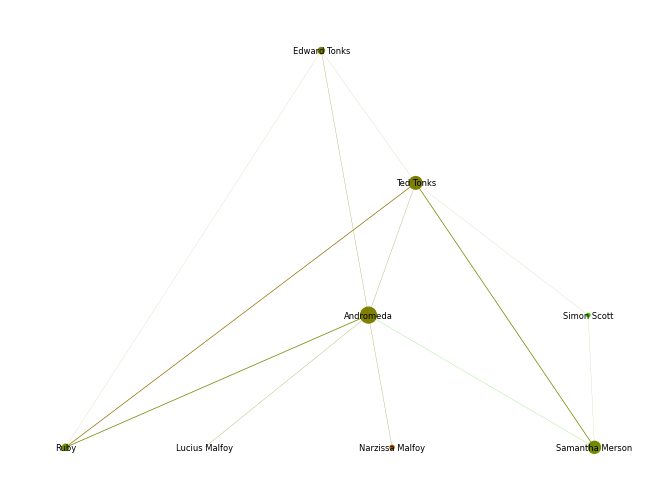

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import math

g = nx.Graph(directed=False)
for f in story.figures:
	if not story.figures[f].relations:
		continue
	g.add_node(f, size=50, font_size=10)

edge_colors = []
edge_widths = []

for f1 in story.figures:
	if story.figures[f1].relations:
		for f2 in story.figures:
			if f1 == f2:
				continue
			if f2 in story.figures[f1].relations and story.figures[f1].relations[f2]:
				s = sum([r[1] for r in story.figures[f1].relations[f2]])
				l = len(story.figures[f1].relations[f2])
				# print(f"{f1} -> {f2} {s} {l} {s/l}")
				g.add_edge(f1, f2)
				edge_colors.append(get_color_for_sentiment(s/l))
				edge_widths.append(s / 30)


char_colors = [get_color_for_sentiment(story.figures[f].sentiment_value) for f in story.figures if story.figures[f].relations]
char_size = [len(story.figures[f1].sentences) * 2 for f1 in story.figures if story.figures[f1].relations]

nx.draw(g,
	with_labels=True,
	pos=graphviz_layout(
		g,
		prog="dot"
	),
	nodelist=[f1 for f1 in story.figures if story.figures[f1].relations],
	font_size=6,
	node_color=char_colors,
	node_size=char_size,
	edge_color=edge_colors,
	width=edge_widths,
)
plt.draw()
plt.show()

## Ergebnisse

Diese Arbeit zeigt zum Einen, dass verschiedene NLP-Modelle noch nicht imstande sind, deutschsprachige literarische Texte sinnvoll zu bewerten.
Die bisherigen Modelle verwenden ungeeignete Ausgangsdaten wie eine (zumeist neutral) gehaltene Wikipedia, Gesetzestexte oder wie im Falle des verwendeten NLPTown-Modells Hotelbewertungen.

Daher sind die resultierenden Graphen nicht so aussagekräftig, wie man sie sich wünschen würde - es gibt nur wenige wirklich negativ bewertete Sätze und damit auch Charaktere.

Allerdings liefert eine Analyse der Beziehungen einzelner Charaktere ein interessantes und wesentlich aussagekräftigeres Bild.
Anhand von einem Netzwerkgraphen kann man erkennen, welche Figuren oft miteinander interagieren und in einigen Fällen lassen sich auch verschiedene Interaktions-Sentiments erkennen.

## Ausblick

Will man diese Ergebnisse aussagekräftiger gestalten, so müssen die Modelle mit sinnvolleren Korpora befüllt und trainiert werden.
Andernfalls werden literarische Texte nicht sinnvoll mittels NLP-Tools untersucht werden können.

Anhand verschiedener Textsorten (Originalwerk und Fan-Fiction) kann man beim Betrachten des Netzwerkgraphen allerdings erkennen, um welches Werk es sich handelt:

![Netzwerkgraph "Harry Potter und der Stein der Weisen"](./img/hp1.png)

![Netzwerkgraph "Hufflepuffgelb und Slytheringrün"](./img/ff.png)

Die Originaltexte haben ein engeres Geflecht an Verbindungen zwischen den Charakteren, Fan Fictions konzentrieren sich hingegen auf weniger Charaktere.